In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_path = load_path('train', 'n', 'neg', data = 'sm')
redspot_path = load_path('train', 'h', 'redspot', data = 'sm')
angio_path = load_path('train', 'h', 'angio', data = 'sm')
active_path = load_path('train', 'h', 'active', data = 'sm')
ero_path = load_path('train', 'd', 'ero', data = 'sm')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm')
str_path = load_path('train', 'd', 'str', data = 'sm')

print("negative:",neg_path.shape)
print("red spot:",redspot_path.shape)
print("angioectasia:",angio_path.shape)
print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (49999,)
red spot: (4448,)
angioectasia: (147,)
active_bleeding: (3430,)
erosion: (5900,)
ulcer: (5856,)
stricture: (825,)


In [3]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
angio_train_path, angio_valid_path = train_valid_split(angio_path)
active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (42499,) (7500,)
red spot: (3781,) (667,)
angioectasia: (125,) (22,)
active bleeding: (2916,) (514,)
erosion: (5015,) (885,)
ulcer: (4978,) (878,)
stricture: (701,) (124,)


# Model

In [38]:
input_h = 512
input_w = 512
input_ch = 3

k_ch = [16, 16, 16, 32, 32, 32, 64, 64, 128]
n_block = len(k_ch)
n_node = [100, 50]
n_layer = len(n_node)
n_node = 0
n_layer = 0
n_output = 2

In [39]:
class CE_cnn:
    def __init__(self, k_ch, n_block, n_node, n_layer, n_output):
        self.k_ch = k_ch
        self.n_block = n_block
        self.n_node = n_node
        self.n_layer = n_layer
        self.n_output = n_output
    def conv_block(self, x, k_ch, n_block):
        for i in range(1, n_block + 1):
            if i == 1:
                conv = tf.layers.conv2d(inputs = x, filters = k_ch[i-1], kernel_size = [3, 3], padding = "SAME", activation= None)
                conv = tf.compat.v1.layers.batch_normalization(conv, training = is_training)
                conv = tf.nn.relu(conv, name = 'block_{}_conv_1'.format(i))
            else:
                conv = tf.layers.conv2d(inputs = conv, filters =k_ch[i-1], kernel_size = [3, 3], padding = "SAME", activation= None)
                conv = tf.compat.v1.layers.batch_normalization(conv, training = is_training)
                conv = tf.nn.relu(conv, name = 'block_{}_conv_1'.format(i))
            conv = tf.layers.conv2d(inputs = conv, filters =  k_ch[i-1], kernel_size = [3, 3], padding = "SAME", activation= None)
            conv = tf.compat.v1.layers.batch_normalization(conv, training = is_training)
            conv = tf.nn.relu(conv, name = 'block_{}_conv_2'.format(i))
            conv = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2, name = 'block_{}_maxp'.format(i))
        return conv
    def fc_layers(self, x, n_node, n_layer, n_output):
        hidden = tf.layers.flatten(x)
        for i in range(1, n_layer + 1):
            hidden = tf.layers.dense(inputs = hidden, units = n_node[i-1],activation = None)
            hidden = tf.compat.v1.layers.batch_normalization(hidden, training = is_training)
            hidden = tf.nn.relu(hidden, name = 'fc_{}'.format(i))   
        score = tf.layers.dense(inputs = hidden, units = n_output, name = 'score')
        return score
    def inf(self, x):
        conv = self.conv_block(x, self.k_ch, self.n_block)
        score = self.fc_layers(conv, self.n_node, self.n_layer, self.n_output)
        return score

In [40]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
LR = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k_ch, n_block, n_node, n_layer, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)
# optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()

# Training

## equal batch-size by class and damaped exp LR

damped_exp_LR(15000) <br>
t_batch = 32 <br>
v_batch = 128 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [41]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

a_train_path = np.hstack([h_train_path, d_train_path])
a_valid_path = np.hstack([h_valid_path, d_valid_path])

a_train_path = shuffle(a_train_path, None)
a_valid_path = shuffle(a_valid_path, None)

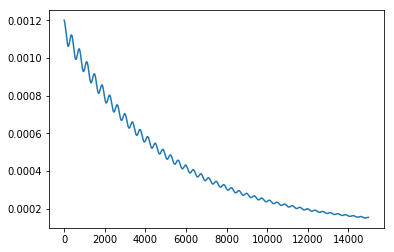

In [45]:
D_lr = damped_exp_LR(15000, A = 0.001)

plt.plot(D_lr)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 50.00 %    || 50.00 %    || 1.50348306 || 1.40716588
--------------------------------------------------------------
[*200] || 50.00 %    || 52.00 %    || 1.46515393 || 1.19349205
--------------------------------------------------------------
[*300] || 78.12 %    || 81.00 %    || 0.59741533 || 0.48469308
--------------------------------------------------------------
[*400] || 68.75 %    || 68.00 %    || 1.16550386 || 1.29199505
--------------------------------------------------------------
[*500] || 78.12 %    || 85.00 %    || 0.51487041 || 0.40354779
--------------------------------------------------------------
[*600] || 50.00 %    || 50.00 %    || 2.09076118 || 1.96469617
--------------------------------------------------------------
[*700] || 53.12 %    || 59.00 %    || 1.37102413 || 1.27468669
--------------------------------------------------------------
[*800] || 78.12 %    || 62.00 %    || 0.44139698 || 0.6

[6500] || 96.88 %    || 98.00 %    || 0.07574600 || 0.05145606
--------------------------------------------------------------
[6600] || 90.62 %    || 92.00 %    || 0.18326584 || 0.18241753
--------------------------------------------------------------
[6700] || 93.75 %    || 95.00 %    || 0.18679520 || 0.11541322
--------------------------------------------------------------
[6800] || 100.00 %    || 93.00 %    || 0.02428998 || 0.17023462
--------------------------------------------------------------
[6900] || 100.00 %    || 94.00 %    || 0.00702534 || 0.18968777
--------------------------------------------------------------
[7000] || 90.62 %    || 94.00 %    || 0.28059077 || 0.13108398
--------------------------------------------------------------
[7100] || 100.00 %    || 98.00 %    || 0.01685314 || 0.07350080
--------------------------------------------------------------
[7200] || 90.62 %    || 97.00 %    || 0.22171086 || 0.08881155
----------------------------------------------------

[13000] || 96.88 %    || 96.00 %    || 0.04446683 || 0.08848286
--------------------------------------------------------------
[13100] || 100.00 %    || 97.00 %    || 0.00127581 || 0.04097153
--------------------------------------------------------------
[13200] || 96.88 %    || 97.00 %    || 0.03624266 || 0.15632503
--------------------------------------------------------------
[13300] || 100.00 %    || 97.00 %    || 0.00553608 || 0.05617858
--------------------------------------------------------------
[13400] || 100.00 %    || 97.00 %    || 0.00432558 || 0.04698495
--------------------------------------------------------------
[13500] || 90.62 %    || 94.00 %    || 0.19589666 || 0.17645542
--------------------------------------------------------------
[13600] || 100.00 %    || 99.00 %    || 0.00516825 || 0.06320145
--------------------------------------------------------------
[13700] || 96.88 %    || 97.00 %    || 0.04188284 || 0.08421180
-------------------------------------------

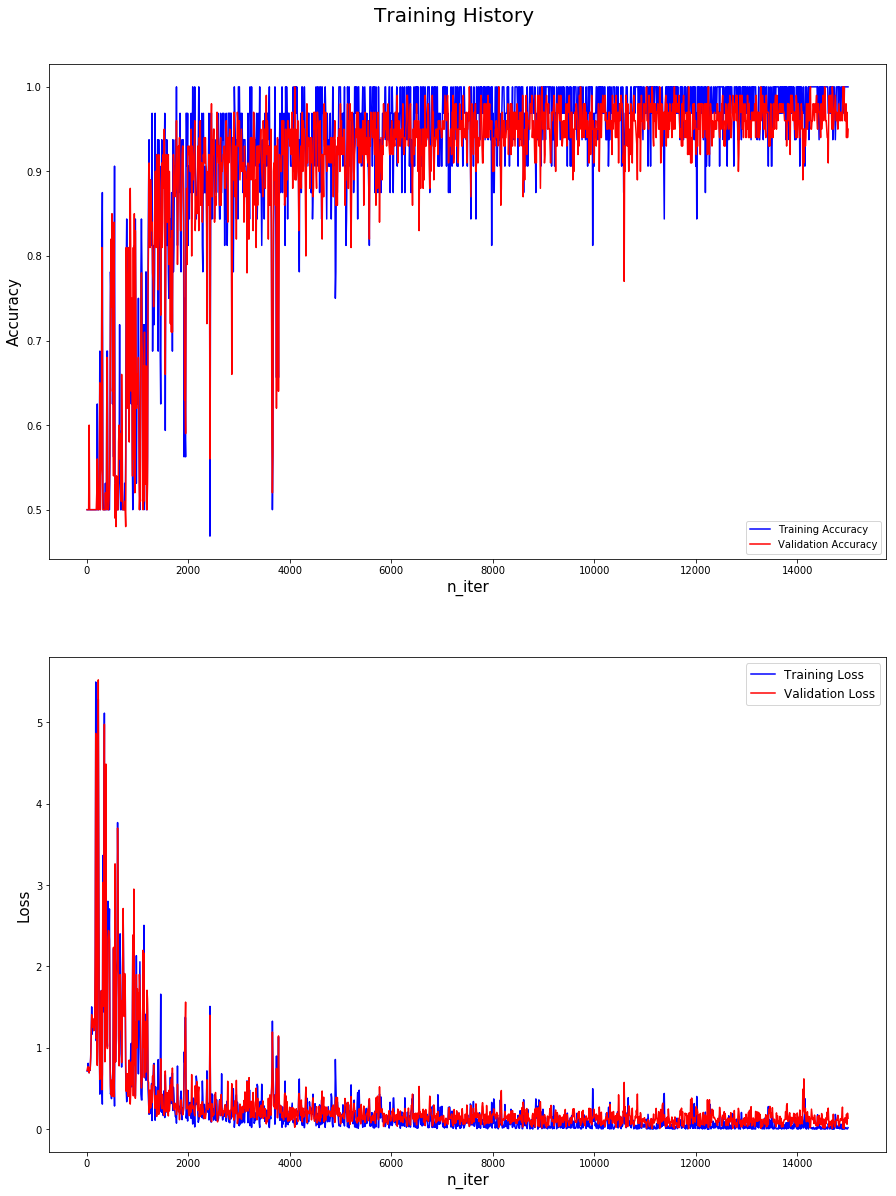

In [46]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
t_batch = 16
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_BN_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 15000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

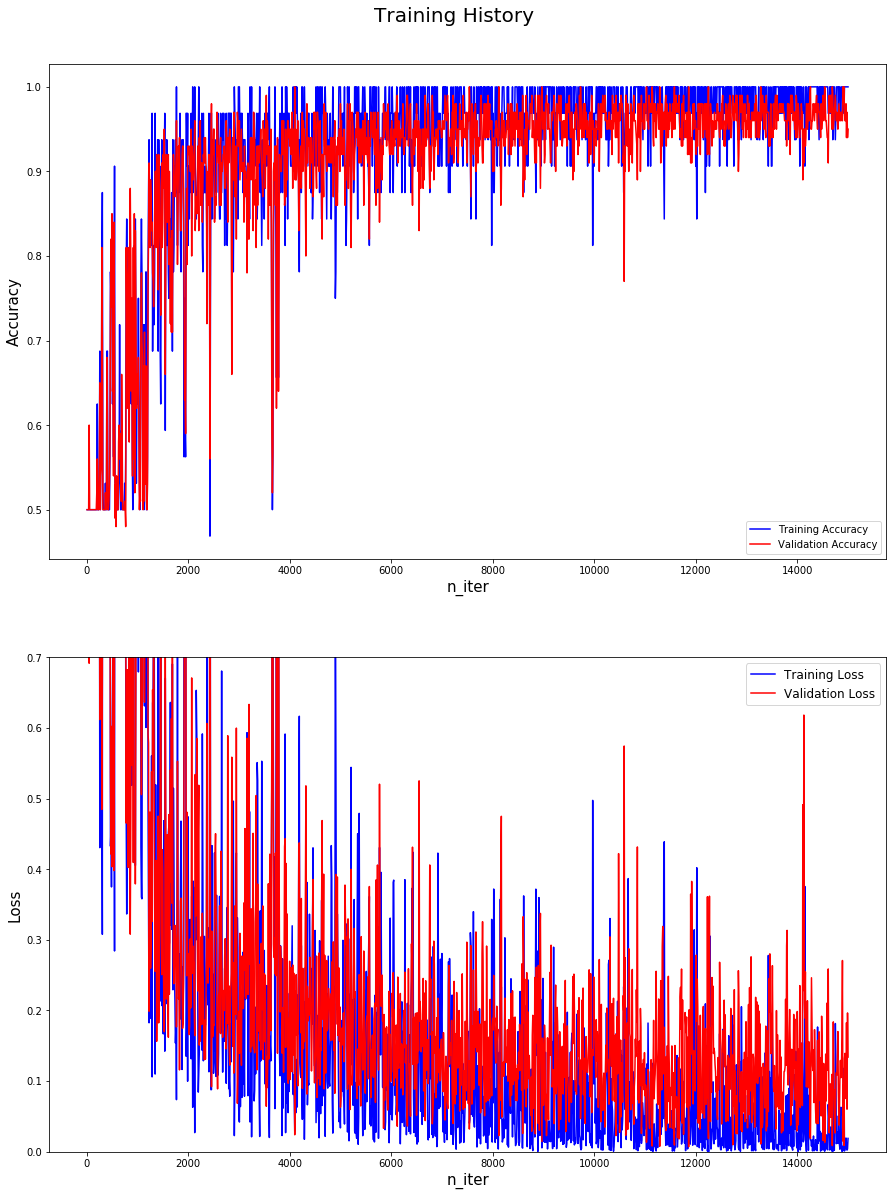

In [48]:
fig = plt.figure(figsize = (15,20))
plt.suptitle('Training History', y = 0.92, fontsize = 20)

#         x_axis = range(1, len(accr_train)+1)
x_axis = range(1, cal_interval*len(accr_train)+1, cal_interval)
x_axis = np.arange(cal_interval, cal_interval*len(accr_train)+1, cal_interval)

plt.subplot(2, 1, 1)
plt.plot(x_axis, accr_train, 'b-', label = 'Training Accuracy')
plt.plot(x_axis, accr_valid, 'r-', label = 'Validation Accuracy')
plt.xlabel('n_iter', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend(fontsize = 10)
plt.subplot(2, 1, 2)
plt.plot(x_axis, loss_train, 'b-', label = 'Training Loss')
plt.plot(x_axis, loss_valid, 'r-', label = 'Validation Loss')
plt.xlabel('n_iter', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim([0, 0.7])
#     plt.yticks(np.arange(0, 0.25, step=0.025))
plt.legend(fontsize = 12)
plt.show()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[15100] || 100.00 %    || 97.00 %    || 0.00255124 || 0.09974961
--------------------------------------------------------------
[15200] || 100.00 %    || 97.00 %    || 0.00120808 || 0.07856432
--------------------------------------------------------------
[15300] || 96.88 %    || 98.00 %    || 0.05186529 || 0.06639376
--------------------------------------------------------------
[15400] || 100.00 %    || 98.00 %    || 0.00131394 || 0.04643814
--------------------------------------------------------------
[15500] || 100.00 %    || 96.00 %    || 0.00160439 || 0.07027847
--------------------------------------------------------------
[15600] || 96.88 %    || 98.00 %    || 0.05562875 || 0.02581706
--------------------------------------------------------------
[15700] || 100.00 %    || 99.00 %    || 0.00146812 || 0.01290908
--------------------------------------------------------------
[15800] || 96.88 %    || 95.00 %    || 0.04

[21400] || 100.00 %    || 94.00 %    || 0.00002852 || 0.23503143
--------------------------------------------------------------
[21500] || 96.88 %    || 95.00 %    || 0.06615213 || 0.33619201
--------------------------------------------------------------
[21600] || 100.00 %    || 98.00 %    || 0.00887141 || 0.09990164
--------------------------------------------------------------
[21700] || 100.00 %    || 99.00 %    || 0.00011179 || 0.02356657
--------------------------------------------------------------
[21800] || 96.88 %    || 97.00 %    || 0.11673170 || 0.12078220
--------------------------------------------------------------
[21900] || 100.00 %    || 99.00 %    || 0.00022822 || 0.03349968
--------------------------------------------------------------
[22000] || 100.00 %    || 100.00 %    || 0.00001865 || 0.00186741
--------------------------------------------------------------
[22100] || 96.88 %    || 97.00 %    || 0.04040065 || 0.07970009
-----------------------------------------

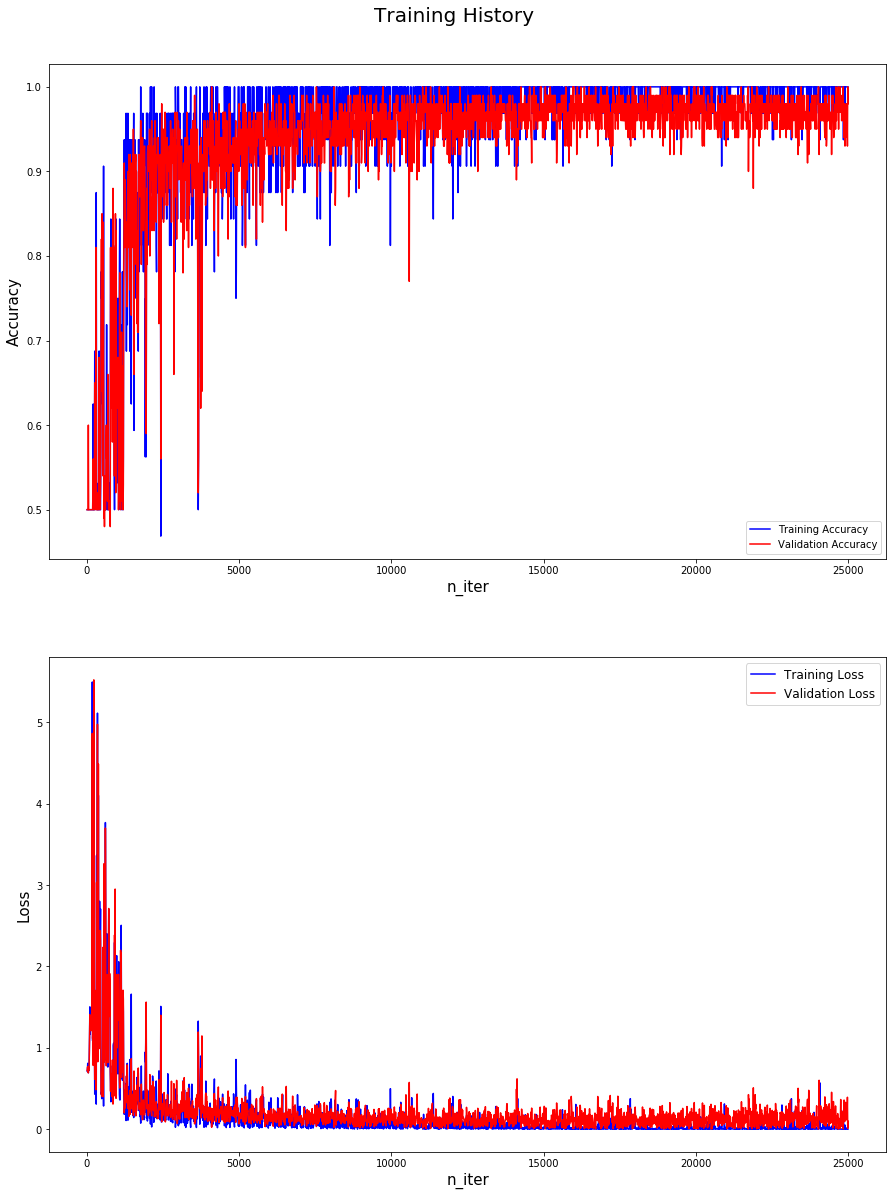

In [49]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: 1e-4})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_BN_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 25000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

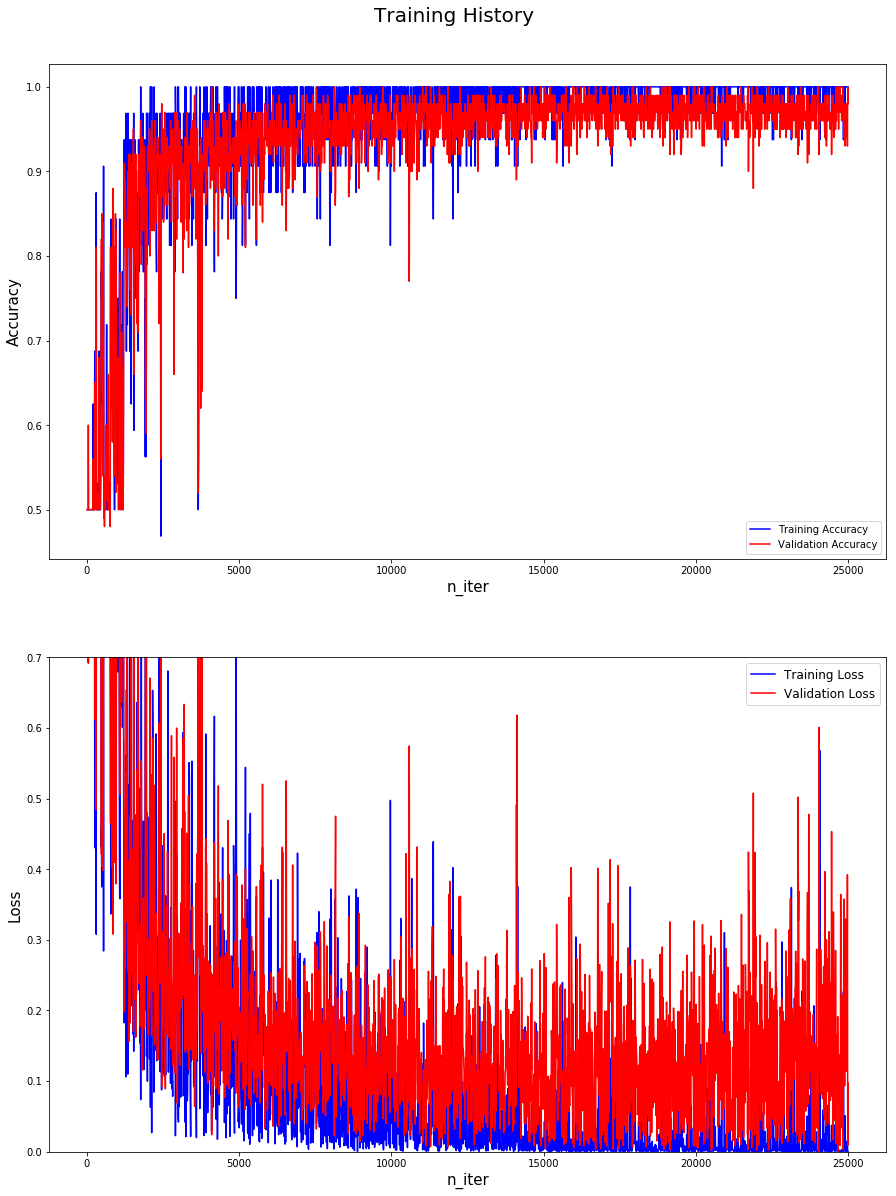

In [50]:
fig = plt.figure(figsize = (15,20))
plt.suptitle('Training History', y = 0.92, fontsize = 20)

#         x_axis = range(1, len(accr_train)+1)
x_axis = range(1, cal_interval*len(accr_train)+1, cal_interval)
x_axis = np.arange(cal_interval, cal_interval*len(accr_train)+1, cal_interval)

plt.subplot(2, 1, 1)
plt.plot(x_axis, accr_train, 'b-', label = 'Training Accuracy')
plt.plot(x_axis, accr_valid, 'r-', label = 'Validation Accuracy')
plt.xlabel('n_iter', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend(fontsize = 10)
plt.subplot(2, 1, 2)
plt.plot(x_axis, loss_train, 'b-', label = 'Training Loss')
plt.plot(x_axis, loss_valid, 'r-', label = 'Validation Loss')
plt.xlabel('n_iter', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim([0, 0.7])
#     plt.yticks(np.arange(0, 0.25, step=0.025))
plt.legend(fontsize = 12)
plt.show()